In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys

# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-27 12:11:43.768977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737976303.780360  869803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737976303.783920  869803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 12:11:43.797435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737976306.194920  869803 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19

In [3]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
val_dir = os.path.join(data_dir, 'validation')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(test_dir,batch_size=1,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1, shuffle=False)
validation_dataset = get_augmented_dataset(val_dir,batch_size=32, shuffle=False)

Found 73230 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 1132 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.


In [6]:
enetb0_model = get_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid", training_base=False)

In [7]:
enetb0_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [8]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [9]:
enetb0_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

change back to python to train:

In [10]:
modelname="effnetv2b0frozen"
enetb0_model,history = train_model(checkpoint_dir="./checkpoints/",
                                   epochs=3,
                                   model=enetb0_model,
                                   train_data=train_dataset,
                                   val_data=validation_dataset,
                                   modelname=modelname
                                   )

Epoch 1/3


I0000 00:00:1737976346.919640  869947 service.cc:148] XLA service 0x72a348002450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737976346.919702  869947 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-27 12:12:28.232458: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737976350.738475  869947 cuda_dnn.cc:529] Loaded cuDNN version 90700


   3/2289 ━━━━━━━━━━━━━━━━━━━━ 1:45 46ms/step - accuracy: 0.6528 - loss: 0.6608   

I0000 00:00:1737976369.369055  869947 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2289/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9742 - loss: 0.0889

2025-01-27 12:15:13.925796: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2428', 144 bytes spill stores, 144 bytes spill loads

2025-01-27 12:15:13.993826: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2428', 520 bytes spill stores, 520 bytes spill loads




Epoch 1: val_loss improved from inf to 0.00396, saving model to ./checkpoints/effnetv2b0frozen.keras
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 242s 85ms/step - accuracy: 0.9742 - loss: 0.0888 - val_accuracy: 0.9986 - val_loss: 0.0040 - learning_rate: 5.0000e-05
Epoch 2/3
2288/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9983 - loss: 0.0058
Epoch 2: val_loss improved from 0.00396 to 0.00218, saving model to ./checkpoints/effnetv2b0frozen.keras
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 174s 76ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9992 - val_loss: 0.0022 - learning_rate: 5.0000e-05
Epoch 3/3
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9983 - loss: 0.0044
Epoch 3: val_loss did not improve from 0.00218
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 176s 76ms/step - accuracy: 0.9983 - loss: 0.0044 - val_accuracy: 0.9992 - val_loss: 0.0030 - learning_rate: 5.0000e-05


In [11]:
from keras.models import load_model
enetb0_model = load_model(f"./checkpoints/{modelname}.keras")

2025-01-27 12:26:58.592231: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


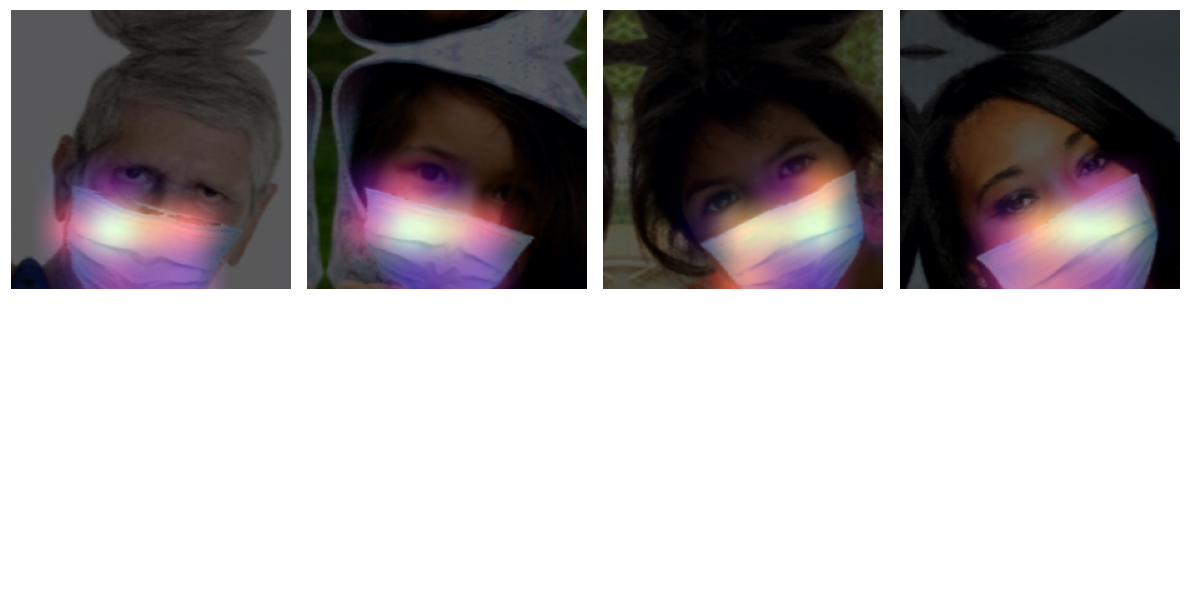

In [12]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2025-01-27 12:27:03.540693: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


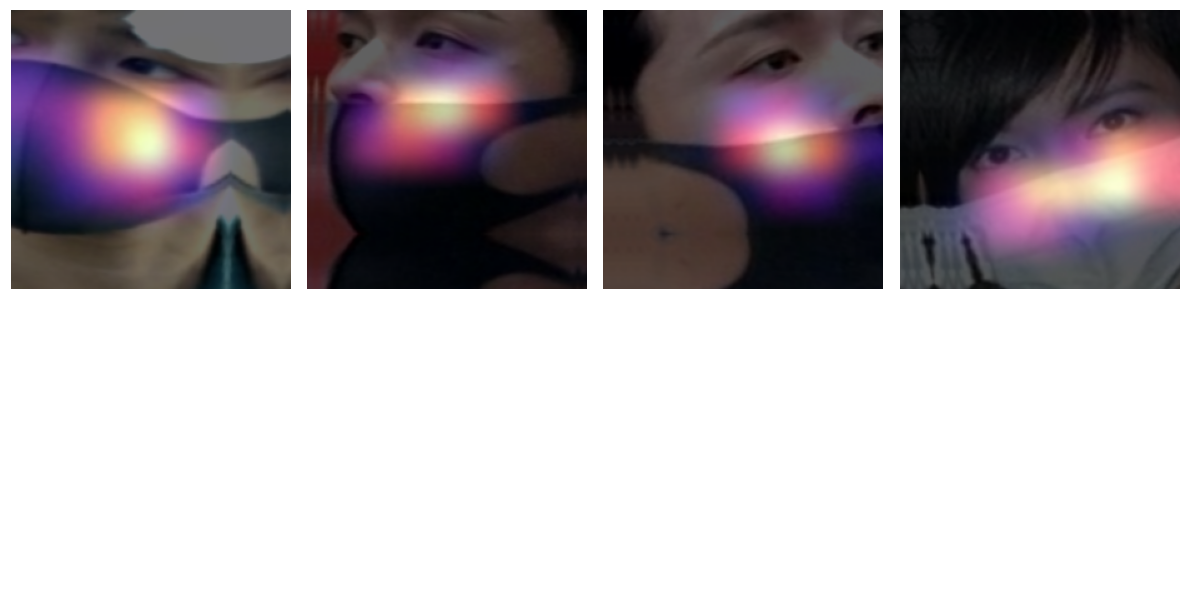

[0, 0, 0, 0]
[0, 0, 0, 0]


In [13]:
import numpy as np
final_images=[]
preds = []
labels = []
for images, label in test_small_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    pred= enetb0_model.predict(images)
    preds.append(int(np.argmax(pred)))
    labels.append(int(np.argmax(label)))
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)
print(labels)
print(preds)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
def create_truncated_viridis():
    """
    Creates a truncated version of the viridis colormap up to dark green.
    
    Returns:
        LinearSegmentedColormap: A new colormap truncated to dark green.
    """
    viridis = plt.cm.get_cmap('viridis')
    
    # Determine the point to truncate the colormap
    # Adjust the trunc_point as needed to capture up to dark green
    trunc_point = 0.5  # Example value; adjust based on visualization
    
    # Generate new colors by sampling the viridis colormap up to trunc_point
    new_colors = viridis(np.linspace(0, trunc_point, 256))
    truncated_viridis = LinearSegmentedColormap.from_list('truncated_viridis', new_colors)
    
    return truncated_viridis
def evaluate_model_seaborn(test_dataset, y_true, y_pred):
    """
    Evaluates the model by computing various metrics and visualizing the confusion matrix using Seaborn.
    
    Args:
        test_dataset (iterable): An iterable of (image, label) tuples.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    
    Returns:
        dict: A dictionary containing evaluation metrics.
        list: A list of misclassified images.
    """
    # Generate classification report and metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    # Create truncated viridis colormap
    truncated_viridis = create_truncated_viridis()
    
    # Plot confusion matrix using seaborn with truncated viridis colormap
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=truncated_viridis,
                xticklabels=classes, yticklabels=classes,
                cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # Identify misclassified samples
    misclassified = []
    for idx, (image, label) in enumerate(test_dataset):
        true_label = np.argmax(label,axis=1)[0]
        pred = y_pred[idx]
        #print(true_label,pred)
        if true_label != pred:
            misclassified.append([image.numpy(),true_label,pred])
    
    # Compile metrics
    metrics = {
        'accuracy': acc,
        'f1_score': f1,
        'matthews_corrcoef': mcc,
        'classification_report': report
    }
    
    return metrics, misclassified

In [15]:
def get_y_true(test_dataset):
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    return y_true
y_true = get_y_true(test_dataset)
y_true = np.argmax(y_true, axis=1)

In [16]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
y_preds= enetb0_model.predict(test_dataset)
y_preds = np.argmax(y_preds, axis=1)

19343/19343 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step


/tmp/ipykernel_869803/941382665.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


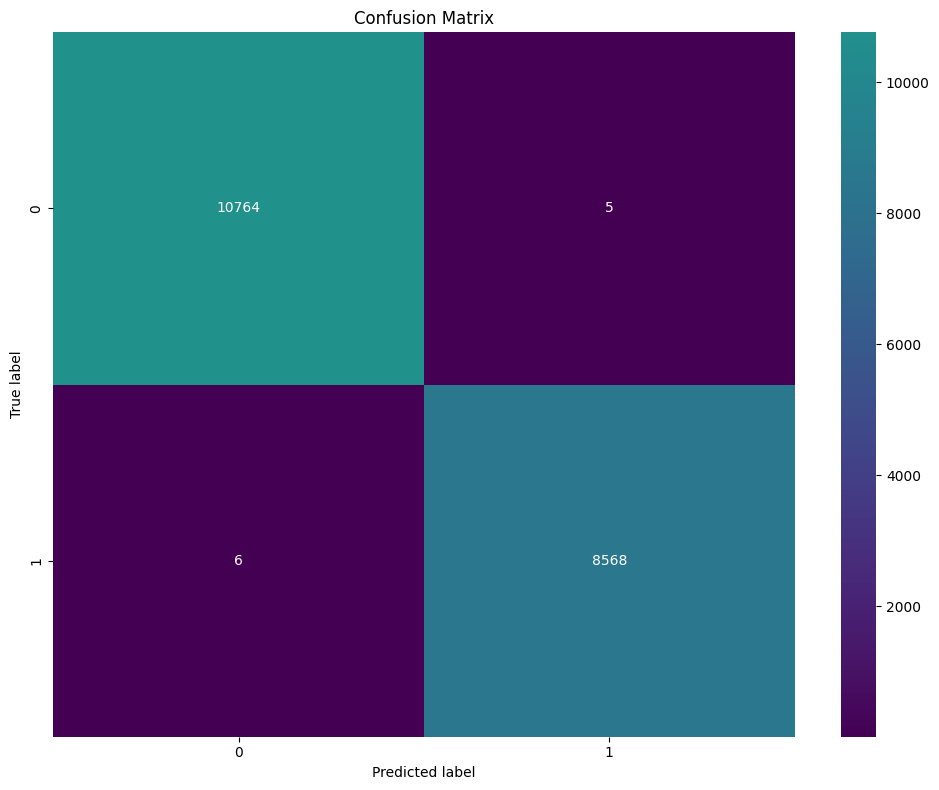

2025-01-27 12:29:29.342535: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
report, misclassified_images = evaluate_model_seaborn(test_dataset,y_true,y_preds)

In [18]:
report

{'accuracy': 0.9994313188233469,
 'f1_score': np.float64(0.9994313154420172),
 'matthews_corrcoef': np.float64(0.9988477923298645),
 'classification_report': {'0': {'precision': 0.9994428969359331,
   'recall': 0.9995357043365215,
   'f1-score': 0.9994892984818237,
   'support': 10769.0},
  '1': {'precision': 0.9994167735915083,
   'recall': 0.9993002099370188,
   'f1-score': 0.9993584883653117,
   'support': 8574.0},
  'accuracy': 0.9994313188233469,
  'macro avg': {'precision': 0.9994298352637208,
   'recall': 0.9994179571367702,
   'f1-score': 0.9994238934235677,
   'support': 19343.0},
  'weighted avg': {'precision': 0.9994313174728148,
   'recall': 0.9994313188233469,
   'f1-score': 0.9994313154420172,
   'support': 19343.0}}}

In [18]:
len(misclassified_images[0])

3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


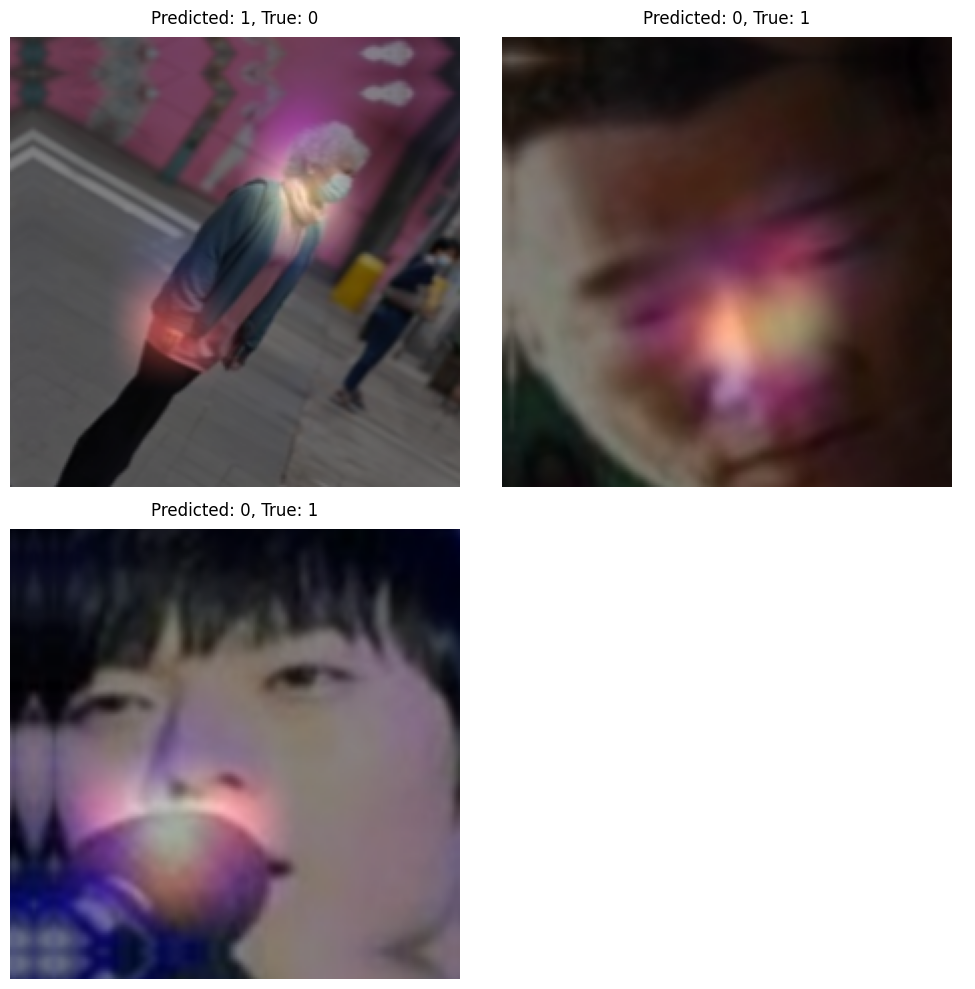

[]
[np.int64(0), np.int64(1), np.int64(0)]


In [ ]:
import numpy as np
final_images=[]
preds = []
labels = []
captions = []
for image in misclassified_images:
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=image[0],
                         )
    pred= np.argmax(enetb0_model.predict(image[0]),axis=1)
    preds.append(pred[0])
    final = superimpose_gradcam(heatmap=heatmap, img=image[0][0],alpha=1)
    final_images.append(final)
    captions.append(f"Predicted: {image[2]}, True: {image[1]}")
p=plot_images_grid(final_images,captions = captions)
print(labels)
print(preds)

In [20]:
misclassified_images[0]

[array([[[[145.2181  ,  94.03427 , 112.22521 ],
          [137.61473 ,  91.94817 , 107.17876 ],
          [130.44714 ,  90.2336  , 102.48283 ],
          ...,
          [ 52.331295,  52.70783 ,  49.70287 ],
          [ 55.212383,  55.371937,  53.343906],
          [ 58.23145 ,  58.34556 ,  57.33099 ]],
 
         [[161.74748 , 100.96955 , 123.620125],
          [153.8791  ,  98.37568 , 118.672775],
          [145.72704 ,  95.71479 , 113.27436 ],
          ...,
          [ 51.70126 ,  52.146458,  48.277554],
          [ 53.264614,  53.55939 ,  50.891857],
          [ 55.141933,  55.28757 ,  53.550198]],
 
         [[176.22702 , 106.43003 , 132.95085 ],
          [169.49916 , 104.97139 , 129.19008 ],
          [161.23428 , 102.54827 , 124.34526 ],
          ...,
          [ 51.758724,  51.590755,  47.709164],
          [ 52.15582 ,  52.478344,  49.546825],
          [ 52.747654,  53.231922,  50.935192]],
 
         ...,
 
         [[162.04312 , 162.14406 , 164.09743 ],
          [163.553